Recovery Threat Model - Denis Dervishi 2024

Importing all necessary libraries and opening up the Wyscout event data for the Premier League 2017/2018 season.

In [1]:
import pandas as pd
import numpy as np
import json
import os
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

path = "events_England.json"
with open(path) as f:
    data = json.load(f)

df = pd.DataFrame(data)
df = df.reset_index()

Defining the end of a possession chain and removing interruptions, lost duels, balls out of the field, and goalkeeper events from the data frame.

In [3]:
next_event = df.shift(-1, fill_value=0)
df["nextEvent"] = next_event["subEventName"]
df["kickedOut"] = df.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)

# Recoveries based possession chains
#interruptions out
interruption = df.loc[df["eventName"] == "Interruption"]
df = df.drop(interruption.index)

# filter out non-accurate duels - in wyscout they are 2 way - attacking and defending
lost_duels = df.loc[df["eventName"] == "Duel"]
lost_duels = lost_duels.loc[lost_duels.apply (lambda x:{"id":1802} in x.tags, axis = 1)]
df = df.drop(lost_duels.index)

# filter ball out of the field
out_of_ball = df.loc[df["subEventName"] == "Ball out of the field"]
df = df.drop(out_of_ball.index)

# save attempts can be dropped
goalies = df.loc[df["subEventName"].isin(["Goalkeeper leaving line", "Save attempt", "Reflexes"])]
df = df.drop(goalies.index)

Defining and calling the function to isolate possession chains from the data frame.

In [5]:
def isolateChains(df):
    df["nextTeamId"] = df.shift(-1, fill_value=0)["teamId"]
    #potential +0s
    chain_team = df.iloc[0]["teamId"]
    period = df.iloc[0]["matchPeriod"]
    stop_criterion = 0
    chain = 0
    df["possession_chain"] = 0
    df["possession_chain_team"] = 0

    for i, row in df.iterrows():
        #add value
        df.at[i, "possession_chain"] = chain
        df.at[i, "possession_chain_team"] = chain_team
        # if pass not accurate/lost duel, add 1 to stop criterion
        if row["eventName"] == "Pass" or row["eventName"] == "Duel":
            if row["teamId"] == chain_team and {"id": 1802} in row["tags"]:
                    stop_criterion += 1
            if row["teamId"] != chain_team and {"id": 1801} in row["tags"]:
                    stop_criterion += 1
        #if ball intercepted properly add 2
        if row["eventName"] == "Others on the ball":
               if row["teamId"] == row["nextTeamId"]:
                   stop_criterion += 2
        #if shot, add 2 to stop criteriom
        if row["eventName"] in ["Shot", "Foul", "Offside"]:
                stop_criterion += 2
        #if ball out of field, add 2
        if row["kickedOut"] == 1:
                stop_criterion += 2
        #criterion for stopping when half ended
        if row["matchPeriod"] != period:
                chain += 1
                stop_criterion = 0
                chain_team = row["teamId"]
                period = row["matchPeriod"]
                df.at[i, "possession_chain"] = chain
                df.at[i, "possession_chain_team"] = chain_team
        #possession chain ended
        if stop_criterion >= 2:
            chain += 1
            stop_criterion = 0
            chain_team = row["nextTeamId"]
    return df

df = isolateChains(df)

Defining and calling the function that combines the Wyscout event data and the possession chain values. Also adds a column if the possession chain ended with a shot or not.

In [7]:
def prepareChains(df):
    df["Shot"] = 0
    #get number of chains
    no_chains = max(df["possession_chain"].unique())
    indicies = []
    for i in range(no_chains+1):
        #all events get possession chain
        possession_chain_df = df.loc[df["possession_chain"] == i]
        #check if the possession chain is not empty
        if len(possession_chain_df) > 0:
            #if ended with shot
            if possession_chain_df.iloc[-1]["eventName"] == "Shot":
                #assign values
                df.loc[df["possession_chain"] == i, "Shot"] = 1
                #check if the previous ones did not end with foul
                k = i-1
                if k > 0:
                    try:
                        prev = df.loc[df["possession_chain"] == k]
                        #create a loop if e.g. 2 chains before and 1 chain before didn;t end with shot
                        while prev.iloc[-1]["eventName"] == "Foul":
                            #assign value for them
                            df.loc[df["possession_chain"] == k, "Shot"] = 1
                            k = k-1
                            prev = df.loc[df["possession_chain"] == k]
                    except:
                        k = k-1
            #get indiices of events made by possession team
            team_indicies = possession_chain_df.loc[possession_chain_df["teamId"] == possession_chain_df.teamId.mode().iloc[0]].index.values.tolist()
            indicies.extend(team_indicies)

    df = df.loc[indicies]
    return df

df = prepareChains(df)

Adding columns to the data frame with coordinates for the starting and ending position of an event. Sets the ending coordinates of the shot to (105, 0).

In [9]:
#filter out dodgy
df = df.loc[df.apply(lambda x: len(x.positions) == 2, axis = 1)]
#columns with coordinates
df["x0"] = df.positions.apply(lambda cell: (cell[0]["x"]) * 105/100)
df["y0"] = df.positions.apply(lambda cell: abs(50 - cell[0]["y"]) * 68/100)
df["x1"] = df.positions.apply(lambda cell: (cell[1]["x"]) * 105/100)
df["y1"] = df.positions.apply(lambda cell: abs(50 - cell[1]["y"]) * 68/100)
#assign (105, 0) to end of the shot
df.loc[df["eventName"] == "Shot", "x1"] = 105
df.loc[df["eventName"] == "Shot", "y1"] = 0

Adding a column to the data frame that shows if the shot ended in a goal (or own goal).

In [11]:
df["Goal"] = df.apply(
    lambda row: 1 if row["eventName"] == "Shot" and 
                ({'id': 101} in row["tags"] or {"id": 102} in row["tags"]) 
                else 0, axis=1)

goal_possession_chains = df.loc[df["Goal"] == 1, "possession_chain"].unique()
df.loc[df["possession_chain"].isin(goal_possession_chains), "Goal"] = 1

print(df["Goal"].sum())
print(df["Shot"].sum())


4396
42315


Removing from the data frame all possession chains that included a set piece because the model is based on recoveries.

In [13]:
chains_to_remove = df[df["eventName"].isin(["Offside", "Free Kick"])]["possession_chain"].unique()
df_filtered = df[~df["possession_chain"].isin(chains_to_remove)]

A column that specifies the length of a specific possession chain will be added to the data frame. This will be used as a feature in the model later on. Also, all possession chains that have 2 or fewer events will be removed, reasoning that such chains are not long enough to be considered possession chains.

In [15]:
# Calculate the length of each possession_chain
df_filtered["possession_chain_count"] = df_filtered.groupby("possession_chain")["possession_chain"].transform("count")

# Add the length of a possession chain next to the appropriate possession chain
df_filtered["possession_chain_count"] = np.where(df_filtered["possession_chain"].notnull(), df_filtered["possession_chain_count"], np.nan)

# Filter out all possession chains that have 2 or less events
df_filtered = df_filtered[df_filtered["possession_chain_count"] >= 3]

Saving the data frame so it can be used for training later on. It takes around 5 minutes for this part to process.

In [17]:
df_filtered.to_json("possession_chains.json", orient="records")

Opening the Wyscout data for players and minutes played in England 2017/2018 season. Loading the possession chains data frame from the saved file (to not waste 5 minutes loading the first part of the code). Only keeping the first event of each possession chain (the recovery event).

In [19]:
path = "minutes_played_per_game_England.json"
with open(path) as f:
    data = json.load(f)

df_players = pd.DataFrame(data)

df = pd.read_json("possession_chains.json",orient="records")
df = df.reset_index()

df_recoveries = df.drop_duplicates(subset="possession_chain", keep="first")


Generating features for the model. Features for this model will be Angle, Distance, X, and the length of the possession chain.

In [21]:
#Generating features
df_recoveries["X"] = df_recoveries.positions.apply(lambda cell: (100 - cell[0]["x"]) * 105 / 100)
df_recoveries["Y"] = df_recoveries.positions.apply(lambda cell: cell[0]["y"] * 68 / 100)
df_recoveries["C"] = df_recoveries.positions.apply(lambda cell: abs(cell[0]["y"] - 50) * 68 / 100)

df_recoveries["Angle"] = np.where(
    np.arctan(7.32 * df_recoveries["X"] / (df_recoveries["X"]**2 + df_recoveries["C"]**2 - (7.32 / 2)**2)) > 0,
    np.arctan(7.32 * df_recoveries["X"] / (df_recoveries["X"]**2 + df_recoveries["C"]**2 - (7.32 / 2)**2)),
    np.arctan(7.32 * df_recoveries["X"] / (df_recoveries["X"]**2 + df_recoveries["C"]**2 - (7.32 / 2)**2)) + np.pi)

df_recoveries["Distance"] = np.sqrt(df_recoveries["X"]**2 + df_recoveries["C"]**2)

filtered_df = df_recoveries[df_recoveries["Shot"] == 1]
filtered_df = df_recoveries[df_recoveries["Goal"] == 1]


Showing a scatter plot to see if there is a correlation between the distance of a recovery from the opposing team's goal and the likelihood the possession chain will result in a shot.

Min: 4.161838536031882, Max: 109.15963035848006


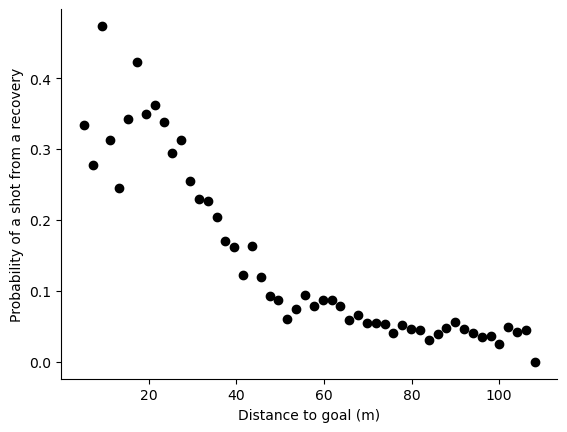

In [23]:
recoveries = df_recoveries.copy()
min_distance = recoveries["Distance"].min()
max_distance = recoveries["Distance"].max()
print(f"Min: {min_distance}, Max: {max_distance}")
shot_count_dist = np.histogram(recoveries["Distance"],bins = int((max_distance-min_distance)/2),range=[min_distance,max_distance])
shots = recoveries.loc[recoveries["Shot"]==1]
actual_shot_count_dist = np.histogram(shots["Distance"],bins = int((max_distance-min_distance)/2),range=[min_distance,max_distance])

prob_shot = np.divide(actual_shot_count_dist[0],shot_count_dist[0])

distance = shot_count_dist[1]
mid_distance = (distance[:-1]+distance[1:])/2

fig,ax = plt.subplots()
ax.plot(mid_distance, prob_shot,linestyle ="none",marker=".", markersize=12,color="black")
ax.set_ylabel("Probability of a shot from a recovery")
ax.set_xlabel("Distance to goal (m)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()
                               

Showing a scatter plot to see if there is a correlation between the length of a possession chain and the likelihood it will end up with a shot.

Min: 3, Max: 48


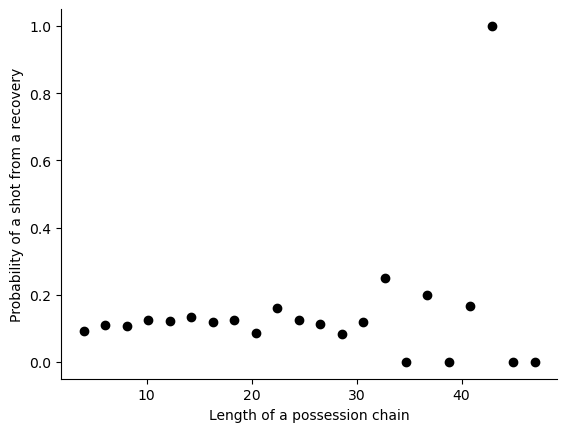

In [25]:
recoveries = df_recoveries.copy()
min_len_possession = recoveries["possession_chain_count"].min()
max_len_possession = recoveries["possession_chain_count"].max()
print(f"Min: {min_len_possession}, Max: {max_len_possession}")
shot_count_dist = np.histogram(recoveries["possession_chain_count"],bins = int((max_len_possession-min_len_possession)/2),range=[min_len_possession,max_len_possession])
shots = recoveries.loc[recoveries["Shot"]==1]
actual_shot_count_dist = np.histogram(shots["possession_chain_count"],bins = int((max_len_possession-min_len_possession)/2),range=[min_len_possession,max_len_possession])

prob_shot = np.divide(actual_shot_count_dist[0],shot_count_dist[0])

distance = shot_count_dist[1]
mid_distance = (distance[:-1]+distance[1:])/2

fig,ax = plt.subplots()
ax.plot(mid_distance, prob_shot,linestyle ="none",marker=".", markersize=12,color="black")
ax.set_ylabel("Probability of a shot from a recovery")
ax.set_xlabel("Length of a possession chain")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

Showing a scatter plot to see if there is a correlation between the distance of a recovery from the opposing team's goal and the likelihood the possession chain will result in a goal.

Min: 4.161838536031882, Max: 109.15963035848006


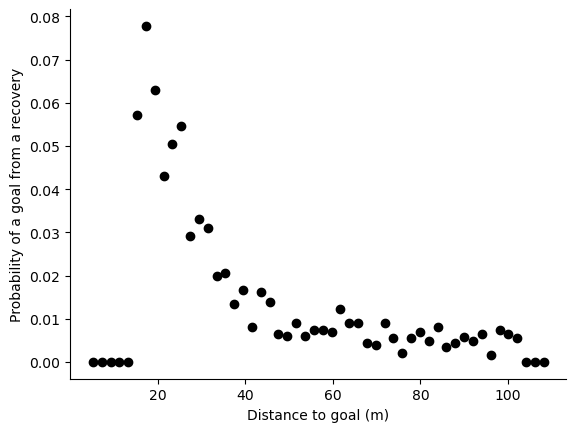

In [27]:
recoveries = df_recoveries.copy()
min_distance = recoveries["Distance"].min()
max_distance = recoveries["Distance"].max()
print(f"Min: {min_distance}, Max: {max_distance}")
goal_count_dist = np.histogram(recoveries["Distance"],bins = int((max_distance-min_distance)/2),range=[min_distance,max_distance])
goals = recoveries.loc[recoveries["Goal"]==1]
actual_goal_count_dist = np.histogram(goals["Distance"],bins = int((max_distance-min_distance)/2),range=[min_distance,max_distance])

prob_goal = np.divide(actual_goal_count_dist[0],goal_count_dist[0])

distance = goal_count_dist[1]
mid_distance = (distance[:-1]+distance[1:])/2

fig,ax = plt.subplots()
ax.plot(mid_distance, prob_goal,linestyle ="none",marker=".", markersize=12,color="black")
ax.set_ylabel("Probability of a goal from a recovery")
ax.set_xlabel("Distance to goal (m)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

Creating two models. Shots from a recovery possession chain and goals from a recovery possession chain. Removing Angle as a feature from goals from a recovery possession chain model because it correlates highly with some other features.

In [29]:
def recoveryShotModel(df):
    shots_model = smf.logit(formula="Shot ~ Distance + Angle + X + possession_chain_count" , data=df).fit()
    print(shots_model.summary())
    recovery_shots_model = shots_model.params
    
    return recovery_shots_model

recovery_shots_params = recoveryShotModel(df_recoveries)

def recoveryGoalModel(df):
    goals_model = smf.logit(formula="Goal ~ Distance + X + possession_chain_count" , data=df).fit()
    print(goals_model.summary())
    recovery_goals_model = goals_model.params
    
    return recovery_goals_model

recovery_goal_params = recoveryGoalModel(df_recoveries)

Optimization terminated successfully.
         Current function value: 0.303507
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   Shot   No. Observations:                36192
Model:                          Logit   Df Residuals:                    36187
Method:                           MLE   Df Model:                            4
Date:                Wed, 04 Dec 2024   Pseudo R-squ.:                 0.07494
Time:                        19:41:26   Log-Likelihood:                -10985.
converged:                       True   LL-Null:                       -11874.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.8415      0.164     -5.126      0.000      -1.163      

Assigning the player names to the recoveries and calculating which ones perform the best in shots from recoveries and goals from recoveries. Before normalization.

In [31]:
df_minutes = df_players.copy()
df_players = df_players.drop_duplicates(subset="playerId")
df_players["shortName"] = df_players["shortName"].map(lambda x: x.encode("utf-8").decode("unicode_escape"))

df_recoveries = df_recoveries.merge(df_players[["playerId", "shortName"]], left_on="playerId", right_on="playerId", how="left")
df_recoveries.drop(columns="playerId", inplace=True)

player_shots = df_recoveries.groupby("shortName")["Shot"].sum().reset_index()
player_shots = player_shots.sort_values(by="Shot", ascending=False).reset_index(drop=True)

player_goals = df_recoveries.groupby("shortName")["Goal"].sum().reset_index()
player_goals = player_goals.sort_values(by="Goal", ascending=False).reset_index(drop=True)


Normalizing the data by minutes played and plotting the best players for both categories. Removing players who played less than 900 minutes (10 matches at least). Philippe Coutinho is first in recovery to shot metric.

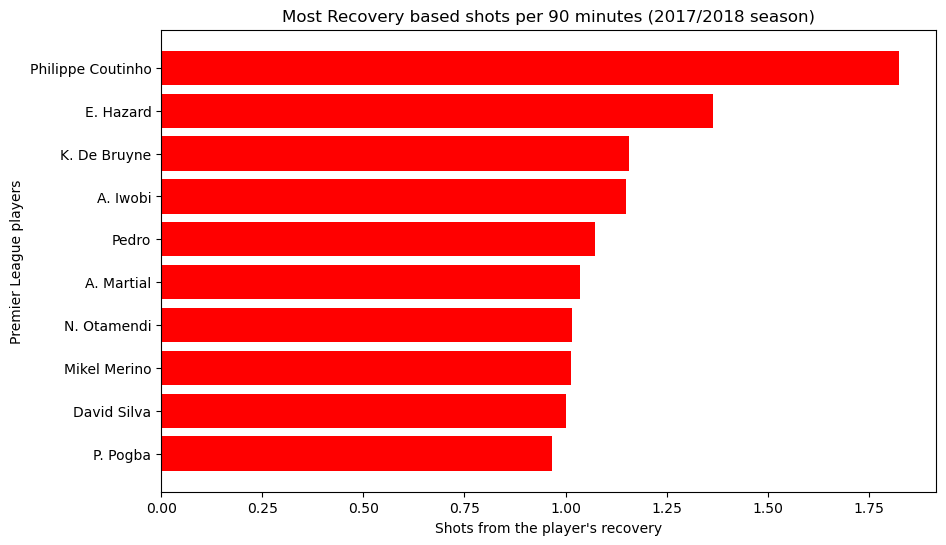

In [33]:
player_minutes = df_minutes.groupby("shortName", as_index=False)["minutesPlayed"].sum()
player_minutes.columns = ["shortName", "total_minutes_played"]
player_minutes = player_minutes[player_minutes["total_minutes_played"] >= 900]
df_players_positions = pd.read_json("players.json")
df_players_positions["Position"] = df_players_positions["role"].apply(lambda x: list(x.values())[-1] if isinstance(x, dict) else None)

normalized_shots = player_shots.merge(player_minutes, on="shortName")
normalized_shots["shots_per_90"] = normalized_shots["Shot"] / (normalized_shots["total_minutes_played"] /90)

sorted_shots = normalized_shots.sort_values(by=["shots_per_90"], ascending=False)
sorted_shots = sorted_shots.merge(df_players_positions[["shortName", "Position"]], on="shortName", how="left")
#sorted_shots = sorted_shots[sorted_shots["Position"] == "Midfielder"]

top_players_shots = sorted_shots.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_players_shots["shortName"], top_players_shots["shots_per_90"], color="red")
plt.xlabel("Shots from the player's recovery")
plt.ylabel("Premier League players")
plt.title("Most Recovery based shots per 90 minutes (2017/2018 season)")
plt.gca().invert_yaxis()
plt.show()

Recovery to goal model best players after normalization. Emre Can is fifth in recovery to goal metric.

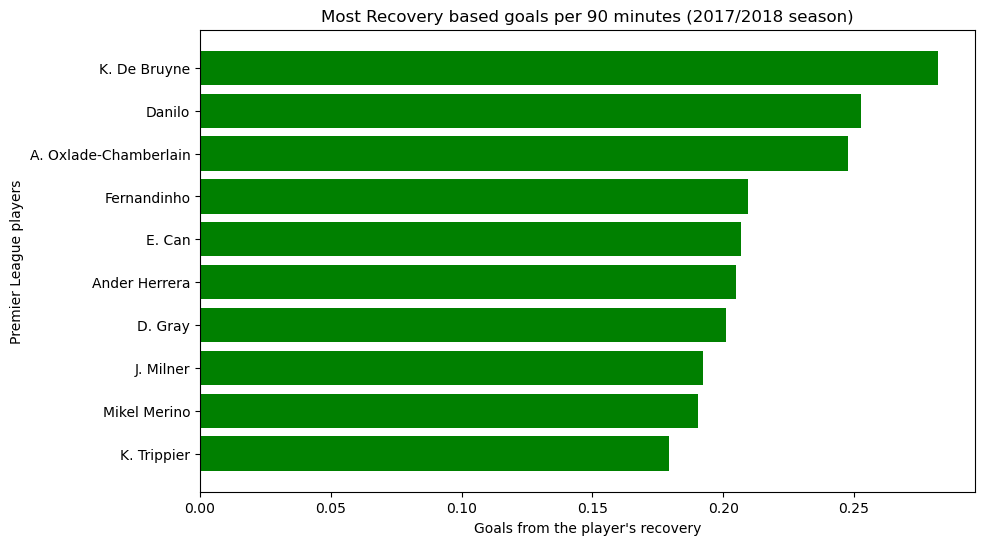

In [35]:
normalized_goals = player_goals.merge(player_minutes, on="shortName")
normalized_goals["goals_per_90"] = normalized_goals["Goal"] / normalized_goals["total_minutes_played"] *90

sorted_goals = normalized_goals.sort_values(by=["goals_per_90"], ascending=False)
sorted_goals = sorted_goals.merge(df_players_positions[["shortName", "Position"]], on="shortName", how="left")
#sorted_goals = sorted_goals[sorted_goals["Position"] == "Midfielder"]

top_players_goals = sorted_goals.head(11)
plt.figure(figsize=(10, 6))
plt.barh(top_players_goals["shortName"], top_players_goals["goals_per_90"], color="green")
plt.xlabel("Goals from the player's recovery")
plt.ylabel("Premier League players")
plt.title("Most Recovery based goals per 90 minutes (2017/2018 season)")
plt.gca().invert_yaxis()
plt.show()

Making a scatter plot of best-performing players in both models in the Premier League 2017/2018 season.

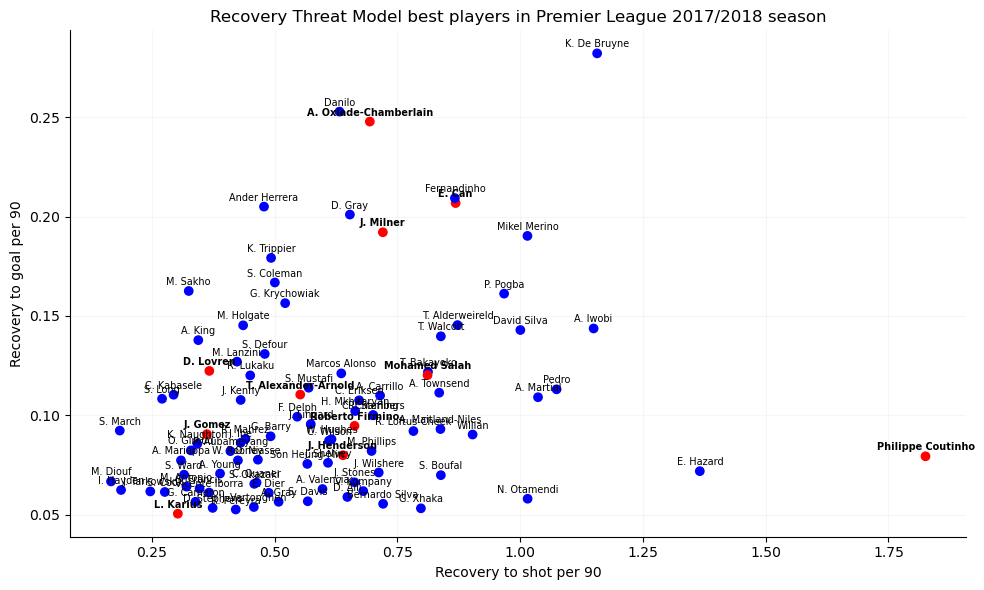

In [37]:
top_prem = pd.merge(sorted_shots,sorted_goals, on ="shortName")
top_prem = top_prem[top_prem["shots_per_90"] > 0.1]
top_prem = top_prem[top_prem["goals_per_90"] > 0.05]
top_prem = pd.merge(top_prem,df_minutes[["shortName","teamName"]],on="shortName",how="left")
columns_to_keep = ["shortName","shots_per_90","goals_per_90","teamName"]
top_prem = top_prem[columns_to_keep]
top_prem = top_prem.drop_duplicates(subset="shortName")

colors = ["red" if team == "Liverpool FC" else "blue" for team in top_prem["teamName"]]

plt.figure(figsize=(10, 6))
plt.grid(True, zorder=0, alpha = 0.1)
plt.scatter(top_prem["shots_per_90"], top_prem["goals_per_90"], color=colors,zorder=2)

plt.title("Recovery Threat Model best players in Premier League 2017/2018 season")
plt.xlabel("Recovery to shot per 90")
plt.ylabel("Recovery to goal per 90")

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

top_prem = top_prem.reset_index()


for i, txt in enumerate(top_prem["shortName"]):
    bolded = "normal"
    x = top_prem["shots_per_90"].iloc[i]
    y = top_prem["goals_per_90"].iloc[i]
    team = top_prem.loc[i, "teamName"]
    if team == "Liverpool FC":
        bolded = "bold"   
    plt.annotate(
        txt,  
        (x, y+0.002),  
        fontsize=7,  
        ha="center",  
        va="bottom",  
        zorder=3,
        fontweight= bolded,
    )

plt.tight_layout()
#plt.savefig("top_prem.jpg", format="jpg", dpi=900)
plt.show()

Time to train the model on the rest of the top 5 leagues (Ligue 1, La Liga, Bundesliga and Serie A) and find players that perform the best in this metric. This data frame was created and saved in this folder already to save 40 minutes of runtime. We also remove players who played less than 15 games and additionaly we isolate only midfielders with reasoning that Liverpool's midfield needs the most strengthening in the summer transfer window in 2018. We notice that Julian Brandt excels at both metrics and Diego Demme is in the top 20 for both metrics as well. They are a good profile of players (age, price, position) to potentially replace Emre Can and Philippe Coutinho in the summer 2018 transfer window.

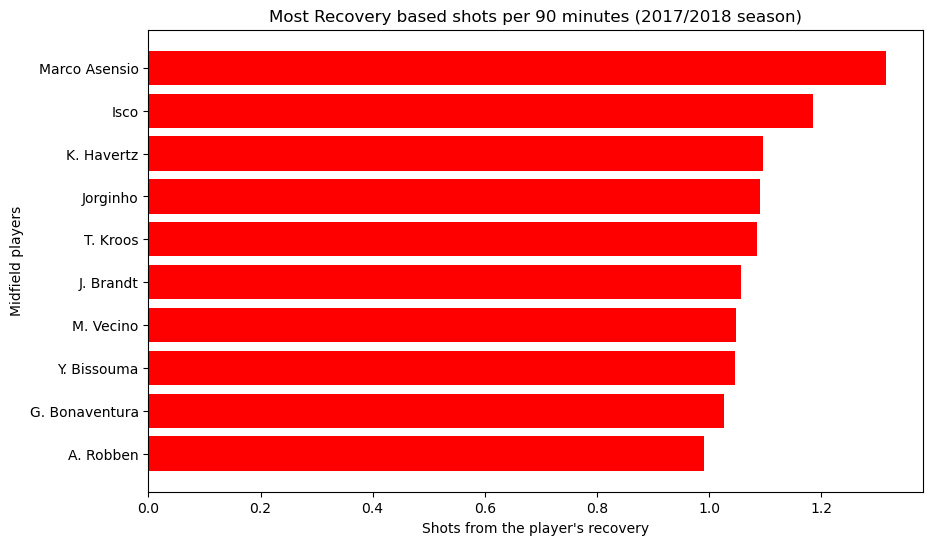

In [39]:
df_sorted_shots_other_leagues = pd.read_json("sorted_shots.json")
df_sorted_shots_other_leagues = df_sorted_shots_other_leagues.merge(df_players_positions[["shortName", "Position"]], on="shortName", how="left")
df_sorted_shots_other_leagues = df_sorted_shots_other_leagues[df_sorted_shots_other_leagues["Position"] == "Midfielder"]
df_sorted_shots_other_leagues = df_sorted_shots_other_leagues[df_sorted_shots_other_leagues["total_minutes_played"] >= 1440]

top_players_shots = df_sorted_shots_other_leagues.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_players_shots["shortName"], top_players_shots["shots_per_90"], color="red")
plt.xlabel("Shots from the player's recovery")
plt.ylabel("Midfield players")
plt.title("Most Recovery based shots per 90 minutes (2017/2018 season)")
plt.gca().invert_yaxis() 
plt.show()

Recovery to goal model (Ligue 1, La Liga, Bundesliga and Serie A) best midfield players after normalization.

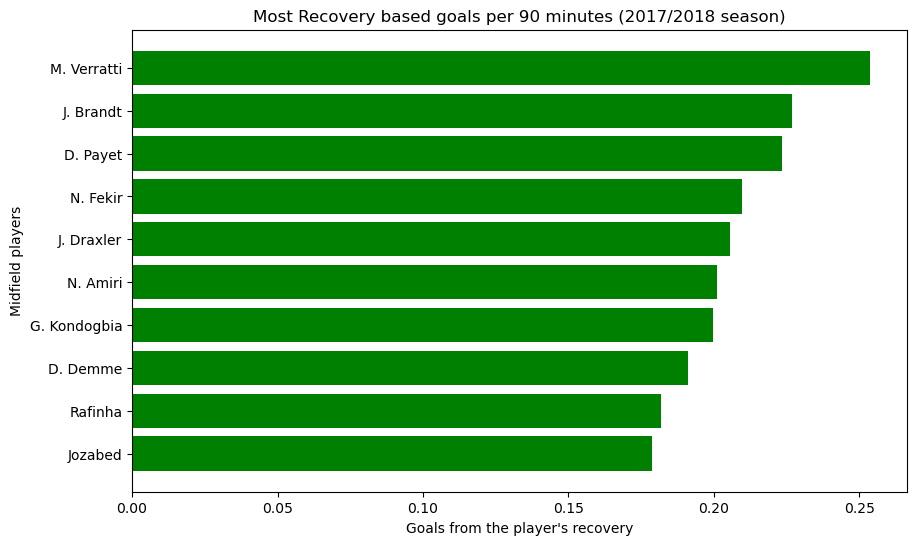

In [41]:
df_sorted_goals_other_leagues = pd.read_json("sorted_goals.json")
df_sorted_goals_other_leagues = df_sorted_goals_other_leagues.merge(df_players_positions[["shortName", "Position"]], on="shortName", how="left")
df_sorted_goals_other_leagues = df_sorted_goals_other_leagues[df_sorted_goals_other_leagues["Position"] == "Midfielder"]
df_sorted_goals_other_leagues = df_sorted_goals_other_leagues[df_sorted_goals_other_leagues["total_minutes_played"] >= 1440]

top_players_goals = df_sorted_goals_other_leagues.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_players_goals["shortName"], top_players_goals["goals_per_90"], color="green")
plt.xlabel("Goals from the player's recovery")
plt.ylabel("Midfield players")
plt.title("Most Recovery based goals per 90 minutes (2017/2018 season)")
plt.gca().invert_yaxis()
plt.show()

Making a scatter plot of best-performing players in both models in La Liga, Bundesliga, Ligue 1, and Serie A in the 2017/2018 season.

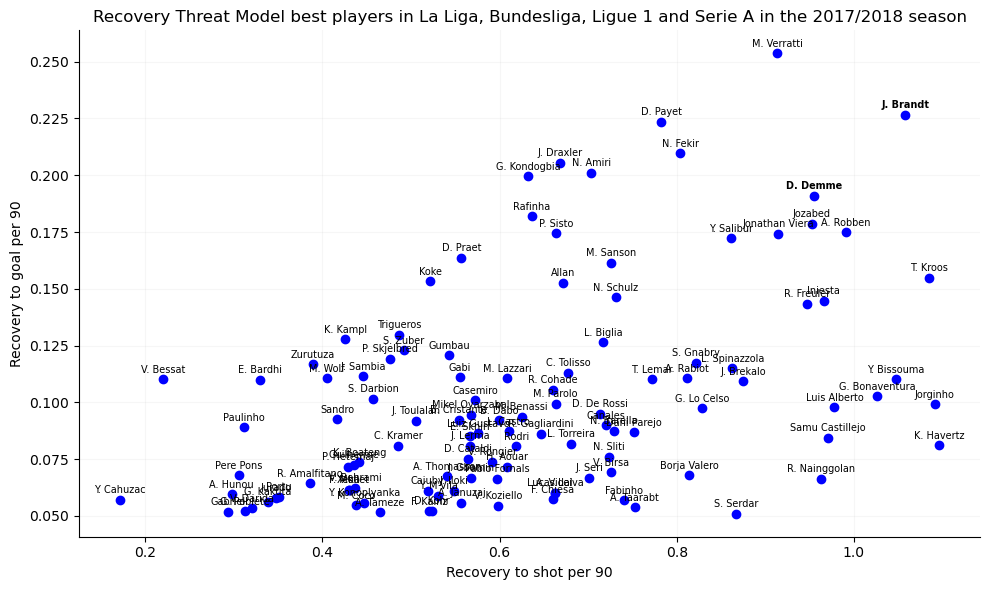

In [43]:
top_other= pd.merge(df_sorted_shots_other_leagues,df_sorted_goals_other_leagues, on ="shortName")
top_other = top_other[top_other["shots_per_90"] > 0.1]
top_other = top_other[top_other["goals_per_90"] > 0.05]
columns_to_keep = ["shortName","shots_per_90","goals_per_90"]
top_other = top_other[columns_to_keep]
top_other = top_other.drop_duplicates(subset="shortName")

plt.figure(figsize=(10, 6))
plt.grid(True, zorder=0, alpha = 0.1)
plt.scatter(top_other["shots_per_90"], top_other["goals_per_90"], color="blue",zorder=2)

plt.title("Recovery Threat Model best players in La Liga, Bundesliga, Ligue 1 and Serie A in the 2017/2018 season")
plt.xlabel("Recovery to shot per 90")
plt.ylabel("Recovery to goal per 90")

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)


for i, txt in enumerate(top_other["shortName"]):
    bolded = "normal"
    x = top_other["shots_per_90"].iloc[i]
    y = top_other["goals_per_90"].iloc[i]
    if txt in ["J. Brandt","D. Demme"]:
        bolded = "bold"
    plt.annotate(
        txt,  
        (x, y+0.002),  
        fontsize=7,  
        ha="center",  
        va="bottom",  
        zorder=3,
        fontweight = bolded,
    )

plt.tight_layout()
#plt.savefig('top_other.jpg', format='jpg', dpi=900)
plt.show()

Building the ROC Curve for Recovery to Shot model.

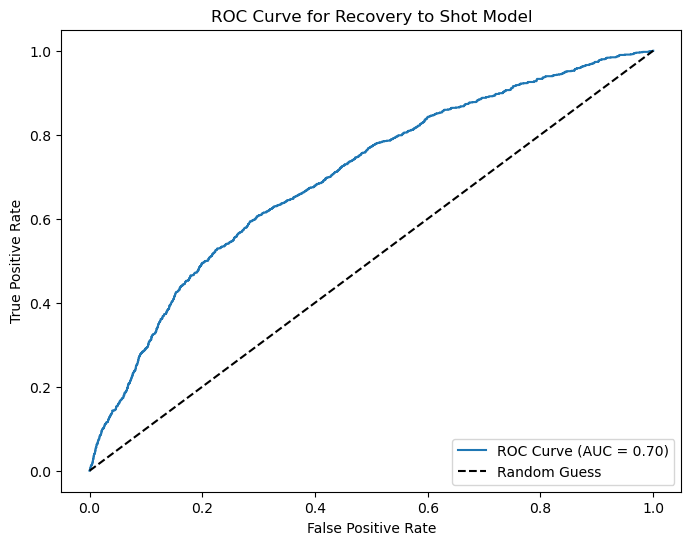

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

X = df_recoveries[["Distance", "Angle", "X", "possession_chain_count"]]
y_shots = df_recoveries["Shot"]

X_train, X_test, y_train, y_test = train_test_split(X, y_shots, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Recovery to Shot Model")
plt.legend(loc="lower right")
plt.show()

Building the ROC Curve for Recovery to Goal model.

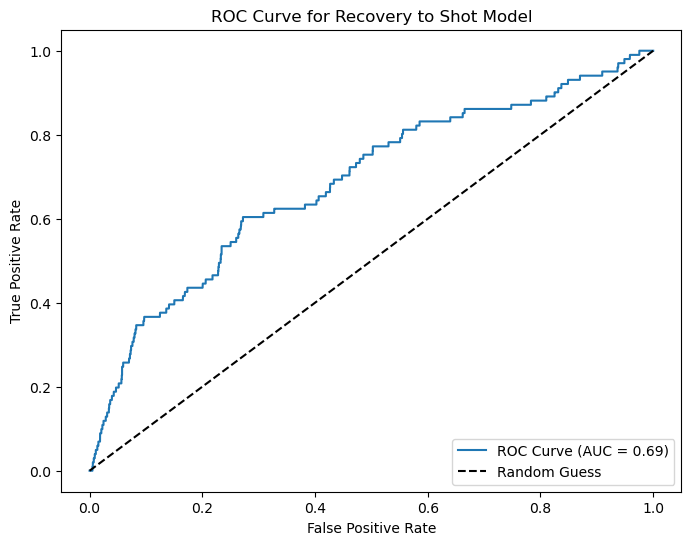

In [49]:
X = df_recoveries[["Distance", "X", "possession_chain_count"]]
y_goals = df_recoveries["Goal"]

X_train, X_test, y_train, y_test = train_test_split(X, y_goals, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Recovery to Shot Model")
plt.legend(loc="lower right")
plt.show()

Analysing Liverpool's recoveries in comparison to other teams in the Premier League 2017/2018 season.

In [51]:
df = pd.read_json("possession_chains.json",orient="records")
df = df.reset_index()
df = df.drop_duplicates(subset="possession_chain", keep="first")

path = "teams.json"
with open(path) as f:
    data = json.load(f)

df_teams = pd.DataFrame(data)
df_teams = df_teams.rename(columns={"wyId": "teamId"})

df = df.merge(df_teams[["teamId", "name"]], on="teamId", how="left")

average_per_team = df.groupby("name")["x0"].mean().sort_values(ascending=False)
average_per_team = average_per_team.reset_index()
average_per_team.columns = ["Team", "Distance"]
average_per_team["Distance"] = average_per_team["Distance"] * 1.05  
print(average_per_team.head(5))

value_counts = df["name"].value_counts().reset_index()
value_counts.columns = ["Team", "Number of Recoveries"]
value_counts["Number of Recoveries"] = value_counts["Number of Recoveries"]/38
print(value_counts.head(5))

                Team   Distance
0    Manchester City  54.567491
1          Liverpool  52.818157
2  Tottenham Hotspur  52.568421
3  Huddersfield Town  51.678517
4  Manchester United  50.579681
                Team  Number of Recoveries
0    Manchester City             69.526316
1          Liverpool             60.394737
2            Arsenal             60.157895
3  Tottenham Hotspur             58.921053
4            Chelsea             58.447368


Plotting the average number of recoveries and average distance of the recoveries in the Premier League 2017/2018 season by team.

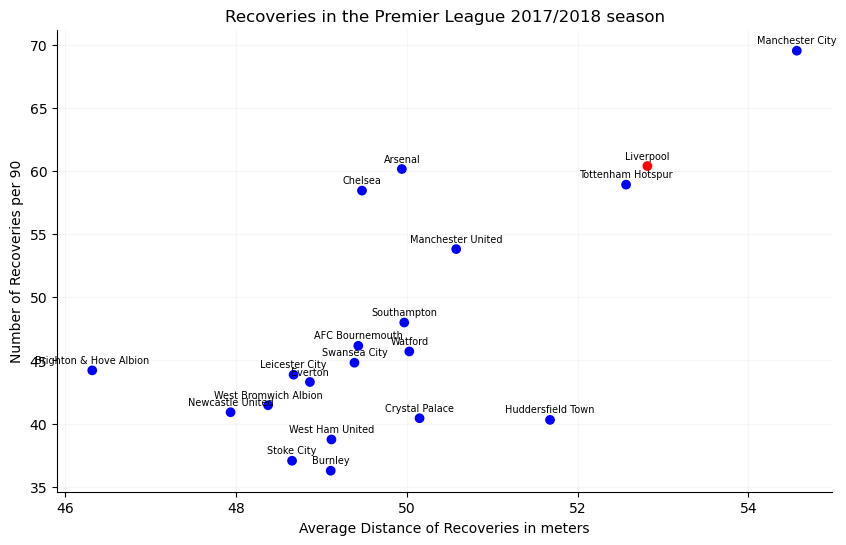

In [55]:
recoveries_prem = pd.merge(average_per_team,value_counts, on ="Team")

colors = ["red" if team == "Liverpool" else "blue" for team in recoveries_prem["Team"]]

plt.figure(figsize=(10, 6))
plt.grid(True, zorder=0, alpha = 0.1)
plt.scatter(recoveries_prem["Distance"], recoveries_prem["Number of Recoveries"], color=colors,zorder=2)

for i, txt in enumerate(recoveries_prem["Team"]):
    plt.annotate(txt, (recoveries_prem["Distance"][i], recoveries_prem["Number of Recoveries"][i]+0.4), fontsize=7, ha="center", va="bottom",zorder=4)

plt.title("Recoveries in the Premier League 2017/2018 season")
plt.xlabel("Average Distance of Recoveries in meters")
plt.ylabel("Number of Recoveries per 90")

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

#plt.savefig("recoveries_prem.jpg", format="jpg", dpi=900)
plt.show()